# Import Libraries

In [1]:
import numpy as np
import torch
import torch.autograd as autograd         # computation graph
from torch import Tensor                  # tensor node in the computation graph
import torch.nn as nn                     # neural networks
import torch.optim as optim               # optimizers e.g. gradient descent, ADAM, etc.
import time
from pyDOE import lhs         #Latin Hypercube Sampling
import matplotlib.pyplot as plt
import matplotlib.ticker

#Set default dtype to float32
torch.set_default_dtype(torch.float)

#PyTorch random number generator
torch.manual_seed(1234)

# Random number generators in other libraries
np.random.seed(1234)

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

print(device)

if device == 'cuda': print(torch.cuda.get_device_name()) 

cuda


# *Data Prep*

Training and Testing data is prepared from the solution file

In [2]:
x_1 = np.linspace(0,22.86,100)  # 256 points between -1 and 1 [256x1]
x_2 = np.linspace(10.16,0,100)  # 256 points between 1 and -1 [256x1]

X, Y = np.meshgrid(x_1,x_2) 

# Test Data

We prepare the test data to compare against the solution produced by the PINN.

In [3]:
X_u_test = np.hstack((X.flatten(order='F')[:,None], Y.flatten(order='F')[:,None]))

# Domain bounds
lb = np.array([0, 0]) #lower bound
ub = np.array([22.86, 10.16])  #upper bound

a_1 = 1.0/22.86
a_2 = 1.0/10.16

k2 = (a_1 * np.pi)**2 + (a_2 * np.pi)**2

usol = np.cos(a_1 * np.pi * X) * np.cos(a_2 * np.pi * Y) #solution chosen for convinience  

u_true = usol.flatten('F')[:,None] 

# Training Data

In [4]:
def trainingdata(N_u,N_f):
    
    leftedge_x = np.hstack((X[:,0][:,None], Y[:,0][:,None]))
    leftedge_u = usol[:,0][:,None]
    
    rightedge_x = np.hstack((X[:,-1][:,None], Y[:,-1][:,None]))
    rightedge_u = usol[:,-1][:,None]
    
    topedge_x = np.hstack((X[0,:][:,None], Y[0,:][:,None]))
    topedge_u = usol[0,:][:,None]
    
    bottomedge_x = np.hstack((X[-1,:][:,None], Y[-1,:][:,None]))
    bottomedge_u = usol[-1,:][:,None]
    
    x_00 = np.array([[0.0, 0.0]])
    u_00 = np.array(1.0)  #???
    
    all_X_u_train = np.vstack([leftedge_x, rightedge_x, bottomedge_x, topedge_x])
    all_u_train = np.vstack([leftedge_u, rightedge_u, bottomedge_u, topedge_u])  
     
    #choose random N_u points for training
    idx = np.random.choice(all_X_u_train.shape[0], N_u, replace=False) 
    
    X_u_train = all_X_u_train[idx[0:N_u], :] #choose indices from  set 'idx' (x,t)
    u_train = all_u_train[idx[0:N_u],:]      #choose corresponding u
    
    '''Collocation Points'''

    # Latin Hypercube sampling for collocation points #内部点
    # N_f sets of tuples(x,t)
    X_f = lb + (ub-lb)*lhs(2,N_f) 
    X_f_train = np.vstack((X_f, X_u_train)) # append training points to collocation points 
    
    return X_f_train, X_u_train, u_train, x_00, u_00, leftedge_x, rightedge_x, topedge_x,bottomedge_x


# Physics Informed Neural Network

In [5]:
class Sequentialmodel(nn.Module):
    
    def __init__(self,layers):
        super().__init__() #call __init__ from parent class 
              
        'activation function'
        self.activation = nn.Tanh()

        'loss function'
        self.loss_function = nn.MSELoss(reduction ='mean')
    
        'Initialise neural network as a list using nn.Modulelist'  
        self.linears = nn.ModuleList([nn.Linear(layers[i], layers[i+1]) for i in range(len(layers)-1)])
        
        '''
        Alternatively:
        
        *all layers are callable 
    
        Simple linear Layers
        self.fc1 = nn.Linear(2,50)
        self.fc2 = nn.Linear(50,50)
        self.fc3 = nn.Linear(50,50)
        self.fc4 = nn.Linear(50,1)
        
        '''
    
        'Xavier Normal Initialization'
        # std = gain * sqrt(2/(input_dim+output_dim))
        for i in range(len(layers)-1):
            
            # weights from a normal distribution with 
            # Recommended gain value for tanh = 5/3?
            nn.init.xavier_normal_(self.linears[i].weight.data, gain=1.0)
            
            # set biases to zero
            nn.init.zeros_(self.linears[i].bias.data)
            

    def forward(self,x):
        
        if torch.is_tensor(x) != True:         
            x = torch.from_numpy(x)                
        
        u_b = torch.from_numpy(ub).float().to(device)
        l_b = torch.from_numpy(lb).float().to(device)
                      
        #preprocessing input 
        x = (x - l_b)/(u_b - l_b) #feature scaling
        
        #convert to float
        a = x.float()
                        
        '''     
        Alternatively:
        
        a = self.activation(self.fc1(a))
        a = self.activation(self.fc2(a))
        a = self.activation(self.fc3(a))
        a = self.fc4(a)
        
        '''
        
        for i in range(len(layers)-2):
            
            z = self.linears[i](a)
                        
            a = self.activation(z)
            
        a = self.linears[-1](a)
        
        return a
    
    def loss_BC(self, x_left, x_right, y_top, y_bottom):
        # Enable gradient tracking for the input tensors
        x_left.requires_grad = True
        x_right.requires_grad = True
        y_top.requires_grad = True
        y_bottom.requires_grad = True

        # Evaluate the neural network predictions at the boundary points
        u_left = self.forward(x_left)
        u_right = self.forward(x_right)
        u_top = self.forward(y_top)
        u_bottom = self.forward(y_bottom)

        # Calculate the derivatives with respect to x and y
        u_x_left = autograd.grad(u_left, x_left, torch.ones_like(u_left), create_graph=True)[0][:, 0]
        u_x_right = autograd.grad(u_right, x_right, torch.ones_like(u_right), create_graph=True)[0][:, 0]
        u_y_top = autograd.grad(u_top, y_top, torch.ones_like(u_top), create_graph=True)[0][:, 1]
        u_y_bottom = autograd.grad(u_bottom, y_bottom, torch.ones_like(u_bottom), create_graph=True)[0][:, 1]

        #   Compute the loss for each boundary
        loss_u_left = self.loss_function(u_x_left, torch.zeros_like(u_x_left))
        loss_u_right = self.loss_function(u_x_right, torch.zeros_like(u_x_right))
        loss_u_top = self.loss_function(u_y_top, torch.zeros_like(u_y_top))
        loss_u_bottom = self.loss_function(u_y_bottom, torch.zeros_like(u_y_bottom))

        # Sum up the losses from all boundaries
        loss_u = loss_u_left + loss_u_right + loss_u_top + loss_u_bottom

        return loss_u

                        
    
    def loss_initial(self,x_0, y_0):
        
        loss_0 = self.loss_function(self.forward(x_0), y_0)
        return loss_0
        
    
    def loss_PDE(self, x_to_train_f):
                
        x_1_f = x_to_train_f[:,[0]]
        x_2_f = x_to_train_f[:,[1]]
        x_1_f.requires_grad = True
        x_2_f.requires_grad = True
#         g = x_to_train_f.clone()
                        
#         g.requires_grad = True
        
        u = self.forward(torch.cat([x_1_f,x_2_f],-1))
                
#         u_x = autograd.grad(u,g,torch.ones([x_to_train_f.shape[0], 1]).to(device), retain_graph=True, create_graph=True)[0]
                                
#         u_xx = autograd.grad(u_x,g,torch.ones(x_to_train_f.shape).to(device), create_graph=True)[0]

        u_x = autograd.grad(u,x_1_f,torch.ones_like(x_1_f), retain_graph=True, create_graph=True)[0]
        u_xx = autograd.grad(u_x,x_1_f,torch.ones_like(x_1_f), retain_graph=True, create_graph=True)[0]
    
        u_y = autograd.grad(u,x_2_f,torch.ones_like(x_2_f), retain_graph=True, create_graph=True)[0]
        u_yy = autograd.grad(u_y,x_2_f,torch.ones_like(x_2_f), retain_graph=True, create_graph=True)[0]
                                                            
#         u_xx_1 = u_xx[:,[0]]
        
#         u_xx_2 = u_xx[:,[1]]
        
        #q = ( -(a_1*np.pi)**2 - (a_2*np.pi)**2 + k2 ) * torch.cos(a_1*np.pi*x_1_f) * torch.cos(a_2*np.pi*x_2_f)
                        
        f = u_xx + u_yy + k2 * u 
        
        
        loss_f = self.loss_function(f,torch.zeros_like(f))
                
        return loss_f
    
    def loss(self,x_0,y_0,x_left,x_right,y_top,y_bottom,x_to_train_f):
        
        loss_0 = self.loss_initial(x_0,y_0)
        loss_u = self.loss_BC(x_left,x_right,y_top,y_bottom)
        loss_f = self.loss_PDE(x_to_train_f)
        
        loss_val = loss_0  + loss_f  + loss_u
        
        
        return loss_val
     
    'callable for optimizer'                                       
    def closure(self):
        
        optimizer.zero_grad()
        
        loss_val = self.loss(xy_0,u_0,xy_left,xy_right,xy_top,xy_bottom, X_f_train)
        
        error_vec, _ = PINN.test()
        
        print(loss,error_vec)
        
        loss_val.backward()

        return loss_val        
    
    def test(self):
                
        u_pred = self.forward(X_u_test_tensor)
        
        error_vec = torch.linalg.norm((u-u_pred),2)/torch.linalg.norm(u,2)        # Relative L2 Norm of the error (Vector)
        
        u_pred = np.reshape(u_pred.cpu().detach().numpy(),(100,100),order='F') 
        
        return error_vec, u_pred

# *Solution Plot*

In [6]:
def solutionplot(u_pred,X_u_train,u_train):

    #Ground truth
    fig_1 = plt.figure(1, figsize=(18, 5))
    plt.subplot(1, 3, 1)
    plt.pcolor(x_1, x_2, usol, cmap='jet')
    plt.colorbar()
    plt.xlabel(r'$x(mm)$', fontsize=18)
    plt.ylabel(r'$y(mm)$', fontsize=18)
    plt.title('Analytical result', fontsize=18)
    
    
    # Prediction
    plt.subplot(1, 3, 2)
    plt.pcolor(x_1, x_2, u_pred, cmap='jet')
    plt.colorbar()
    plt.xlabel(r'$x(mm)$', fontsize=18)
    plt.ylabel(r'$y(mm)$', fontsize=18)
    plt.title('Predicted result by PINN', fontsize=18)
    
   
    # Error
    plt.subplot(1, 3, 3)
    #plt.pcolor(x_1, x_2, np.abs(usol - u_pred), cmap='jet',vmin=0, vmax=1)
    plt.pcolor(x_1, x_2, np.abs(usol - u_pred), cmap='jet',vmin=0, vmax=0.05)
    plt.colorbar()
    plt.xlabel(r'$x(mm)$', fontsize=18)
    plt.ylabel(r'$y(mm)$', fontsize=18)
    plt.title('Absolute error', fontsize=18)
    plt.tight_layout()

    plt.savefig('Helmholtz_non_stiff_PINN_TE11.png', dpi = 500, bbox_inches='tight')

# Main

In [7]:
N_u = 200 #Total number of data points for 'u'
N_f = 400 #Total number of collocation points 

# Training data
X_f_train_np_array, X_u_train_np_array, u_train_np_array, x_00_np_array, u_00_np_array,leftedge_x_np_array, rightedge_x_np_array, topedge_x_np_array,bottomedge_x_np_array = trainingdata(N_u,N_f)

'Convert to tensor and send to GPU'
X_f_train = torch.from_numpy(X_f_train_np_array).float().to(device)
X_u_train = torch.from_numpy(X_u_train_np_array).float().to(device)
u_train = torch.from_numpy(u_train_np_array).float().to(device)
xy_0 = torch.from_numpy(x_00_np_array).float().to(device)
xy_left = torch.from_numpy(leftedge_x_np_array).float().to(device)
xy_right = torch.from_numpy(rightedge_x_np_array).float().to(device)
xy_top = torch.from_numpy(topedge_x_np_array).float().to(device)
xy_bottom = torch.from_numpy(bottomedge_x_np_array).float().to(device)
u_0 = torch.from_numpy(u_00_np_array).float().to(device)
X_u_test_tensor = torch.from_numpy(X_u_test).float().to(device)
u = torch.from_numpy(u_true).float().to(device)
# f_hat = torch.zeros(X_f_train.shape[0],1).to(device)

layers = np.array([2, 50, 50, 50, 1]) #3 hidden layers

PINN = Sequentialmodel(layers)
       
PINN.to(device)

'Neural Network Summary'

print(PINN)

params = list(PINN.parameters())




'Adam Optimizer'

optimizer = optim.Adam(PINN.parameters(), lr=0.01,foreach=True)
scd = optim.lr_scheduler.StepLR(optimizer, step_size=50, gamma = 0.988)

max_iter = 20000

start_time = time.time()

for i in range(max_iter):

    loss = PINN.loss(xy_0,u_0,xy_left,xy_right,xy_top,xy_bottom, X_f_train)
    
    print('epcho=',i,'loss= ',loss.data)
           
    optimizer.zero_grad()     # zeroes the gradient buffers of all parameters
    
    loss.backward() #backprop

    optimizer.step()
    scd.step()
    
    if i % (max_iter/100) == 0:

        error_vec, _ = PINN.test()

        print(loss,error_vec)
    
    
elapsed = time.time() - start_time                
print('Training time: %.2f' % (elapsed))


''' Model Accuracy ''' 
error_vec, u_pred = PINN.test()

print('Test Error: %.5f'  % (error_vec))


''' Solution Plot '''
# solutionplot(u_pred,X_u_train,u_train)

Sequentialmodel(
  (activation): Tanh()
  (loss_function): MSELoss()
  (linears): ModuleList(
    (0): Linear(in_features=2, out_features=50, bias=True)
    (1-2): 2 x Linear(in_features=50, out_features=50, bias=True)
    (3): Linear(in_features=50, out_features=1, bias=True)
  )
)


C:\Users\Symphony\anaconda3\envs\pytorch\lib\site-packages\torch\nn\modules\loss.py:535: UserWarning: Using a target size (torch.Size([])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


epcho= 0 loss=  tensor(1.0021, device='cuda:0')
tensor(1.0021, device='cuda:0', grad_fn=<AddBackward0>) tensor(1.5032, device='cuda:0', grad_fn=<DivBackward0>)
epcho= 1 loss=  tensor(0.5749, device='cuda:0')
epcho= 2 loss=  tensor(0.1102, device='cuda:0')
epcho= 3 loss=  tensor(0.2006, device='cuda:0')
epcho= 4 loss=  tensor(0.1959, device='cuda:0')
epcho= 5 loss=  tensor(0.0418, device='cuda:0')
epcho= 6 loss=  tensor(0.0282, device='cuda:0')
epcho= 7 loss=  tensor(0.0844, device='cuda:0')
epcho= 8 loss=  tensor(0.1009, device='cuda:0')
epcho= 9 loss=  tensor(0.0733, device='cuda:0')
epcho= 10 loss=  tensor(0.0339, device='cuda:0')
epcho= 11 loss=  tensor(0.0099, device='cuda:0')
epcho= 12 loss=  tensor(0.0128, device='cuda:0')
epcho= 13 loss=  tensor(0.0310, device='cuda:0')
epcho= 14 loss=  tensor(0.0383, device='cuda:0')
epcho= 15 loss=  tensor(0.0277, device='cuda:0')
epcho= 16 loss=  tensor(0.0132, device='cuda:0')
epcho= 17 loss=  tensor(0.0077, device='cuda:0')
epcho= 18 loss= 

' Solution Plot '

In [13]:
# '''Optimization'''

# 'L-BFGS Optimizer'

lbfgs_optimizer = optim.LBFGS(PINN.parameters(), lr=1.0, 
                               max_iter=10000,
                               max_eval = None, 
                               tolerance_grad = 1e-10, 
                               tolerance_change = 1e-10, 
                               history_size = 150, 
                               line_search_fn = 'strong_wolfe')
start_time = time.time()
 # 使用 LBFGS 进行优化
def lbfgs_closure():
    lbfgs_optimizer.zero_grad()
    loss = PINN.loss(xy_0, u_0, xy_left, xy_right, xy_top, xy_bottom, X_f_train)
    print('epoch=', lbfgs_optimizer.state['n_iter'], 'loss= ', loss.item())
    loss.backward()
    return loss

# 自动迭代次数
lbfgs_optimizer.step(lbfgs_closure)
    

elapsed = time.time() - start_time
print('Training time: %.2f' % elapsed)

''' Model Accuracy '''
error_vec, u_pred = PINN.test()
print('Test Error: %.5f' % error_vec)


 

 #optimizer.zero_grad()     # zeroes the gradient buffers of all parameters

 #optimizer.step(PINN.closure)

epoch= {} loss=  6.749940553163469e-07
epoch= {} loss=  6.764059321540117e-07
epoch= {} loss=  6.749764906999189e-07
Training time: 0.20
Test Error: 0.05736


In [9]:
 #存数据
import numpy as np

# Assuming X_u_test and u_pred are NumPy arrays
data_exact = np.column_stack((X_u_test, u_true))
np.savetxt('exact_mm100.txt', data_exact, delimiter=',', header='x_1,x_2,u_true', comments='')

print('X_u_test.shape',X_u_test.shape)
print(' u_pred.shape = ', u_pred.shape)

data_pinn = np.column_stack((X_u_test, u_pred.reshape(-1,1)))
np.savetxt('pinn_mm100.txt', data_pinn, delimiter=',', header='x_1,x_2,u_pred', comments='')




OSError: [Errno 22] Invalid argument: 'exact_mm100.txt'

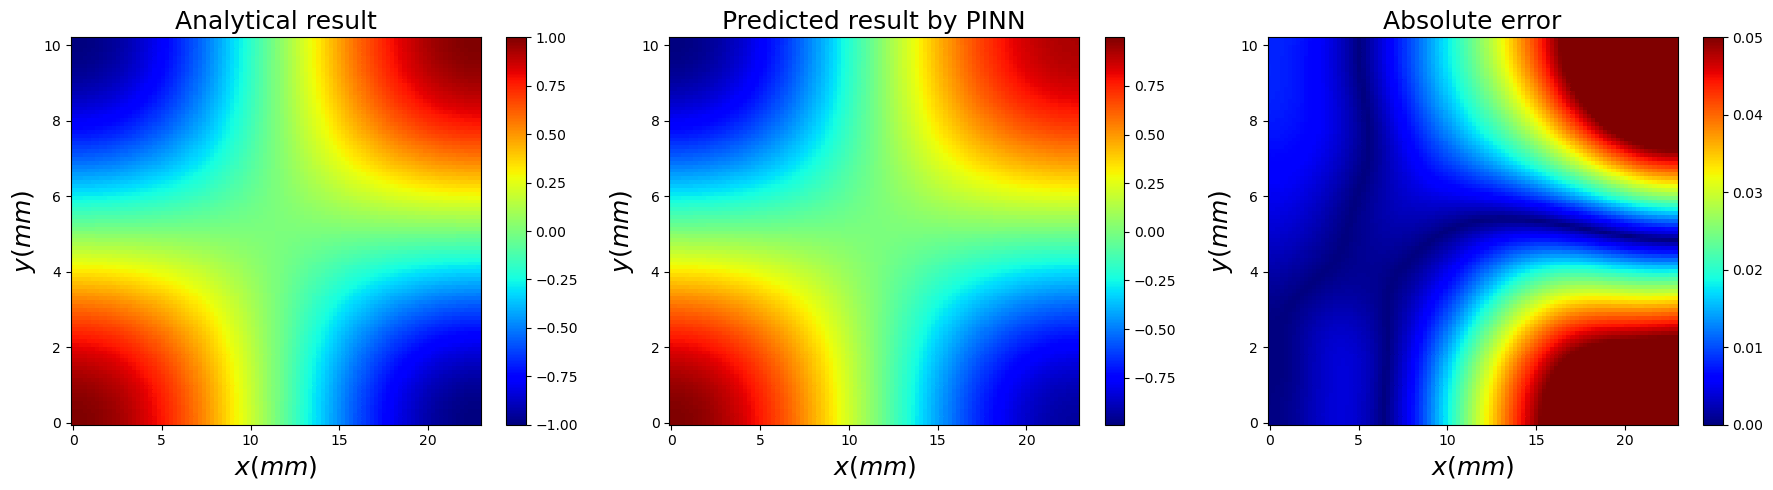

In [9]:
solutionplot(u_pred,X_u_train,u_train)